<a href="https://colab.research.google.com/github/swastik-nayek/DJANGO_BCT/blob/main/Forest_Cover_Type_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np # Generally useful for numerical operations

# Upload the train.csv file
from google.colab import files
print("Please upload 'train.csv':")
uploaded = files.upload() # This will open a prompt to upload the file
df = pd.read_csv('train.csv')

print(df.head())
print(df.info())

Please upload 'train.csv':


Saving train.csv to train (3).csv
   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...         

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns # For quick visualizations

# Check for missing values - should be none based on typical datasets of this kind
print("\nMissing values in the dataset:", df.isnull().sum().sum())

# Define features (X) and target (y)
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Split data into training and testing sets (stratified for class balance)
# Using a smaller test size (0.15) can sometimes speed up evaluation, but 0.2 is common.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Engineering (Fast and effective)
# Combine horizontal and vertical distance to hydrology
X_train['Distance_To_Hydrology'] = np.sqrt(X_train['Horizontal_Distance_To_Hydrology']**2 + X_train['Vertical_Distance_To_Hydrology']**2)
X_test['Distance_To_Hydrology'] = np.sqrt(X_test['Horizontal_Distance_To_Hydrology']**2 + X_test['Vertical_Distance_To_Hydrology']**2)

# Calculate sum of hillshade features (simple combination)
X_train['Hillshade_Sum'] = X_train['Hillshade_9am'] + X_train['Hillshade_Noon'] + X_train['Hillshade_3pm']
X_test['Hillshade_Sum'] = X_test['Hillshade_9am'] + X_test['Hillshade_Noon'] + X_test['Hillshade_3pm']

# Numerical columns for scaling (including new engineered features)
numerical_cols_to_scale = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
    'Distance_To_Hydrology', 'Hillshade_Sum' # Our engineered features
]

# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling to numerical columns
# Use .copy() to avoid SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test_scaled[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

print("\nShape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("\nFirst 5 rows of scaled training data:\n", X_train_scaled.head())


Missing values in the dataset: 0

Shape of X_train_scaled: (12096, 57)
Shape of X_test_scaled: (3024, 57)

First 5 rows of scaled training data:
           Id  Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
14128  14129   0.459435 -0.048570  1.240066                          0.710974   
4425    4426   0.284791  1.299527 -0.885929                         -0.651024   
909      910   0.425942  1.253983 -1.240262                         -0.050983   
5123    5124   0.184311 -0.112332  0.177069                         -0.508157   
10901  10902  -0.456850  1.636551 -0.295375                         -0.936758   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
14128                        2.272350                         0.158238   
4425                        -1.009344                        -0.036874   
909                         -0.489472                         2.538151   
5123                        -0.440733                         0.405531

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize LightGBM Classifier with GPU support and reasonable parameters
# 'goss' boosting_type can be faster for some datasets
# 'class_weight' balanced helps with potential class imbalance
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=7, # There are 7 classes
    random_state=42,
    n_estimators=1000, # Start with a higher number, and use early stopping
    learning_rate=0.05,
    num_leaves=31, # Default is often a good start
    max_depth=-1, # No limit on depth, can grow deep
    n_jobs=-1, # Use all available cores/GPUs
    # tree_learner='data_parallel', # If you have multiple GPUs, this could be faster
    # device='gpu' # Explicitly enable GPU
)

print("\nTraining LightGBM Classifier...")
# Use early stopping to prevent overfitting and speed up training if convergence is reached
lgb_model.fit(X_train_scaled, y_train,
              eval_set=[(X_test_scaled, y_test)],
              eval_metric='multi_logloss',
              callbacks=[lgb.early_stopping(100, verbose=True)]) # Stop if validation metric doesn't improve for 100 rounds

print("Training complete.")

# Make predictions
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Evaluate the model
print("\nLightGBM Classifier Performance (Initial Model):")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))


Training LightGBM Classifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 47
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's multi_logloss: 0.338519
Training complete.

LightGBM Classifier Performance (Initial Model):
Accuracy: 0.8763227513227513

Classification Report:
               precision    recall  f1-sc


Starting Fast Hyperparameter Tuning for LightGBM (CPU)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2793
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 47
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

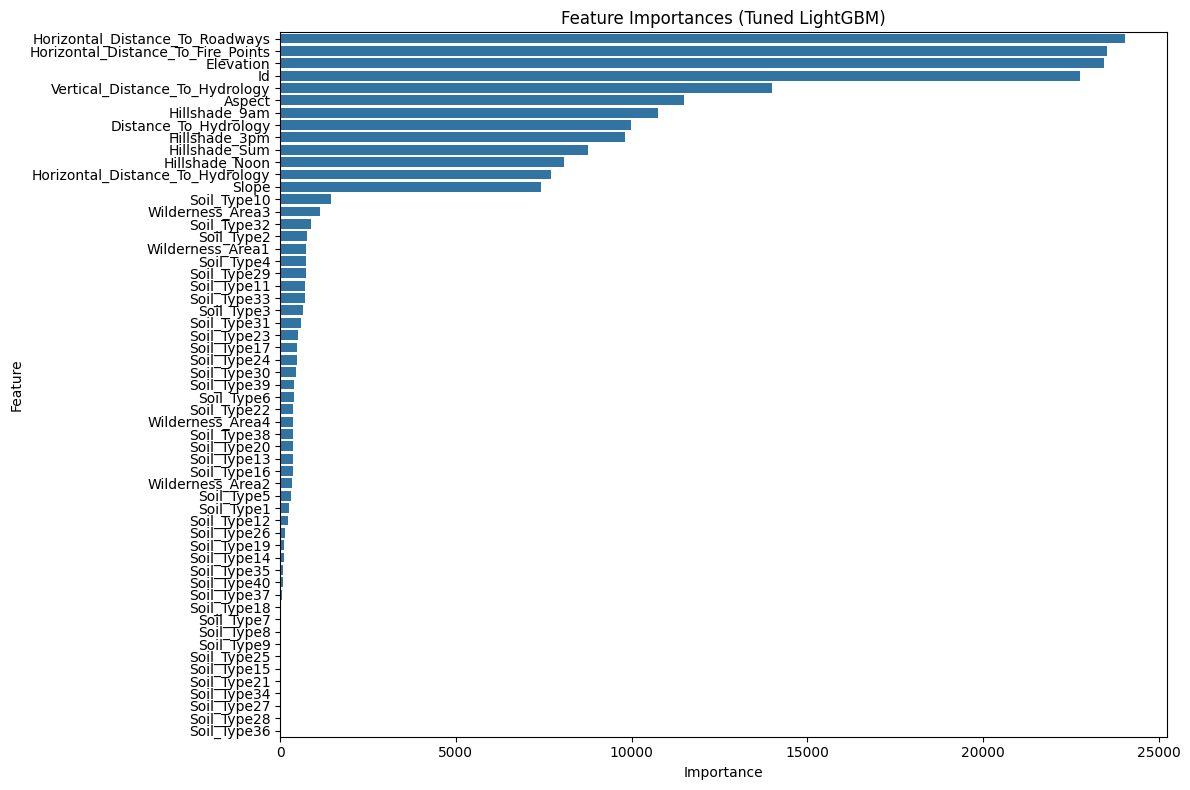

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a more focused parameter distribution (faster tuning)
param_dist_lgb = {
    'n_estimators': [500, 700, 1000],
    'learning_rate': [0.03, 0.05, 0.07],
    'num_leaves': [25, 31, 40],
    'max_depth': [-1, 15, 25],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.2],
    'reg_lambda': [0.0, 0.1, 0.2]
}

print("\nStarting Fast Hyperparameter Tuning for LightGBM (CPU)...")
random_search_lgb = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(
        objective='multiclass',
        num_class=7,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1  # CPU parallelization
    ),
    param_distributions=param_dist_lgb,
    n_iter=15,  # Controls speed/quality tradeoff
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search_lgb.fit(X_train_scaled, y_train)
print("✅ Tuning complete.")

# Show best results
print("\nBest parameters:", random_search_lgb.best_params_)
print("Best CV f1_weighted score: {:.4f}".format(random_search_lgb.best_score_))

# Train final model
best_lgb_model = random_search_lgb.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test_scaled)

# Evaluation
print("\n🎯 Tuned LightGBM Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))

# Feature Importances
importances = best_lgb_model.feature_importances_
feature_names = X_train_scaled.columns
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=importance_series.values, y=importance_series.index)
plt.title('Feature Importances (Tuned LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
import joblib

# Get the best estimator after tuning
best_lgb_model_tuned = random_search_lgb.best_estimator_

# Save the trained model and the scaler
joblib.dump(best_lgb_model_tuned, 'forest_cover_prediction_model_tuned.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("\n✅ Tuned model and scaler saved successfully.")


✅ Tuned model and scaler saved successfully.
